# Multi-channel MR Image Reconstruction Challenge - Getting Started


In this jupyter notebook, we illustrate the basics for loading the data of the multi-channel magnetic resonance image reconstruction challenge. More specifically, we illustrate how to load and display samples from the train, validation and test sets. We also illustrate how to load the sampling patterns provided for R = 5 and R = 10 and use them to retrospectively undersample k-space. R indicates the acceleration factor.

In [1]:
# Some basic Python libraries
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import os
import matplotlib.gridspec as gridspec
import glob
import sys
import h5py
# Add our module to the path
sys.path.append("../../Modules/") 
from utils import sum_of_squares

The data are saved as HDF5 files (.h5). For the train and validation sets, you get the fully sampled k-spaces stored in the format x-ky-kz-nchannels (*i.e.*, inverse Fourier Transform (iFT) in the frequency-encoded direction, k-space in the phase-encoded and slice-encoded directions, and number of coil channels).  This allows to undersample in both the phase-encoded and slice-encoded directions while still being able to model the problem as a 2D problem, where you can reconstruct slice-by-slice in the frequency-encoded direction. The channels dimension of the array alternate between real and imaginary components of the complex values, therefore for the 12-channel data you get 24 channels in the last dimension of the array, and for the 32-channel data you get 64. Remember that the dataset was partially acquired in the slice-encoded direction.

The cell below illustrates how to load a slice. Display the channel-wise k-spaces, their counterpats in image domain and how to combine the channels using root sum of squares. 

Number of volumes in the train set 47
Data format is x-ky-kz-nchannels
data shape: (256, 218, 170, 24)


Channel-wise k-space


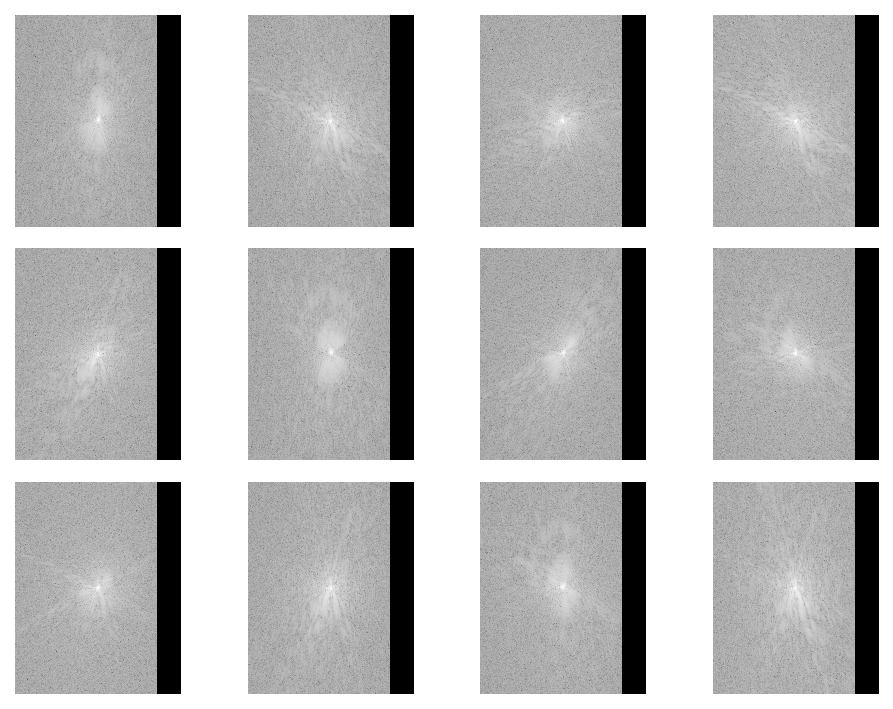

Channel-wise images


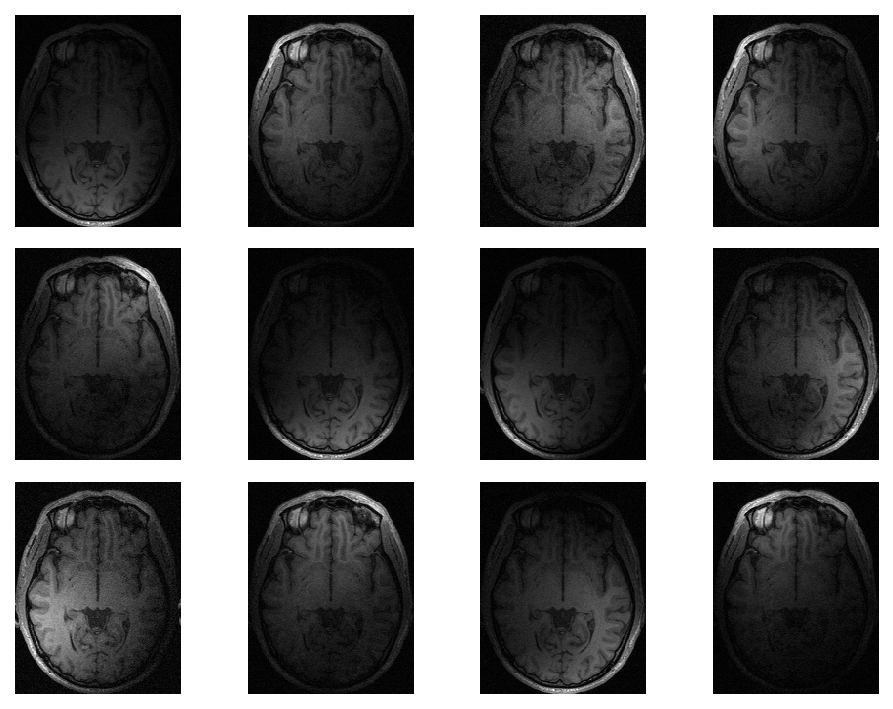

Sum of squares


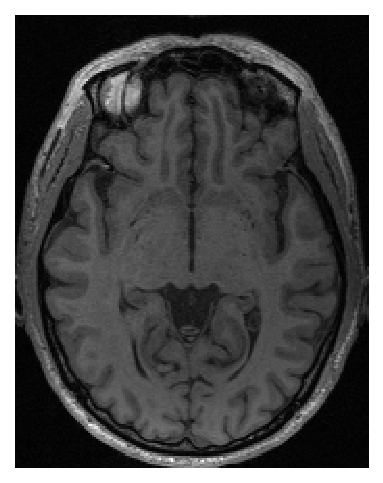

In [2]:
# 12-channel data
train_path = "/media/roberto/ROBERTO-5TB/GDrive/CC359/Raw-data/Multi-channel/12-channel/Train/*.h5"
train_files = np.asarray(glob.glob(train_path))
print("Number of volumes in the train set",len(train_files))


# Displaying a specific slice from a specific volume
file_index = 25
slice_index = 125


sr = 0.85 # Sampling-rate in the slice-encode direction

# Load .h5 file
with h5py.File(train_files[file_index], 'r') as f:
    sample_kspace = f['kspace'][:] # the key to access data is 'kspace'

# Explicit zero-filling after 85% in the slice-encoded direction
Nz = sample_kspace.shape[2]
Nz_sampled = int(np.ceil(Nz*sr))
sample_kspace[:,:,Nz_sampled:,:] = 0

print("Data format is x-ky-kz-nchannels")
print("data shape:",sample_kspace.shape)

# We just want to show one slice
sample_kspace = sample_kspace[slice_index]
# Converting to complex
sample_kspace = sample_kspace[:,:,::2] + 1j*sample_kspace[:,:,1::2]


print("\n\nChannel-wise k-space")    

# Displaying channels' k-spaces
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(3, 4)
gs1.update(wspace=0.002, hspace=0.1)

for ii in range(12):
    plt.subplot(gs1[ii])
    plt.imshow(np.log(1+np.abs(sample_kspace[:,:,ii])),cmap = "gray")
    plt.axis("off")
plt.show()

print("Channel-wise images")    
sample_rec_train = np.fft.ifft2(sample_kspace,axes = (0,1)) # Only ky and kz are in k-space domain

# Displaying channels' images
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(3, 4)
gs1.update(wspace=0.002, hspace=0.1)

for ii in range(12):
    plt.subplot(gs1[ii])
    plt.imshow(np.abs(sample_rec_train[:,:,ii]),cmap = "gray")
    plt.axis("off")
plt.show()

print("Sum of squares")

sos = sum_of_squares(sample_rec_train)
plt.figure(dpi = 150)
plt.imshow(sos,cmap = "gray")
plt.axis("off")
plt.show()

You need to apply retrospective undersampling to get the samples in a proper way to train your model. We provide 100 sampling patterns for R = 5 and R=10 for the different image sizes in the dataset. The sampling pattenrs follow a Poisson disc distribution where the centre of k-space was fully sampled within a radius of 16. 

We provide 100 sampling patterns for R=5 and R=10
(100, 218, 170)
Average sampling rate: 0.20013540018981335
(100, 218, 170)
Average sampling rate: 0.09988706105662765


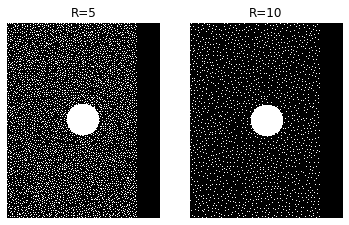

In [4]:
sp_r5 = np.load("../../Data/poisson_sampling/R5_218x170.npy")
sp_r10 = np.load("../../Data/poisson_sampling/R10_218x170.npy")

print("We provide 100 sampling patterns for R=5 and R=10")
print(sp_r5.shape)
print("Average sampling rate:",sp_r5[:,:,:Nz_sampled].sum()/sp_r5[:,:,:Nz_sampled].size)
print(sp_r10.shape)
print("Average sampling rate:",sp_r10[:,:,:Nz_sampled].sum()/sp_r10[:,:,:Nz_sampled].size)

plt.figure()
plt.subplot(121)
plt.imshow(sp_r5[0],cmap ="gray")
plt.axis("off")
plt.title("R=5")
plt.subplot(122)
plt.imshow(sp_r10[0],cmap ="gray")
plt.title("R=10")
plt.axis("off")
plt.show()



Channel-wise k-space


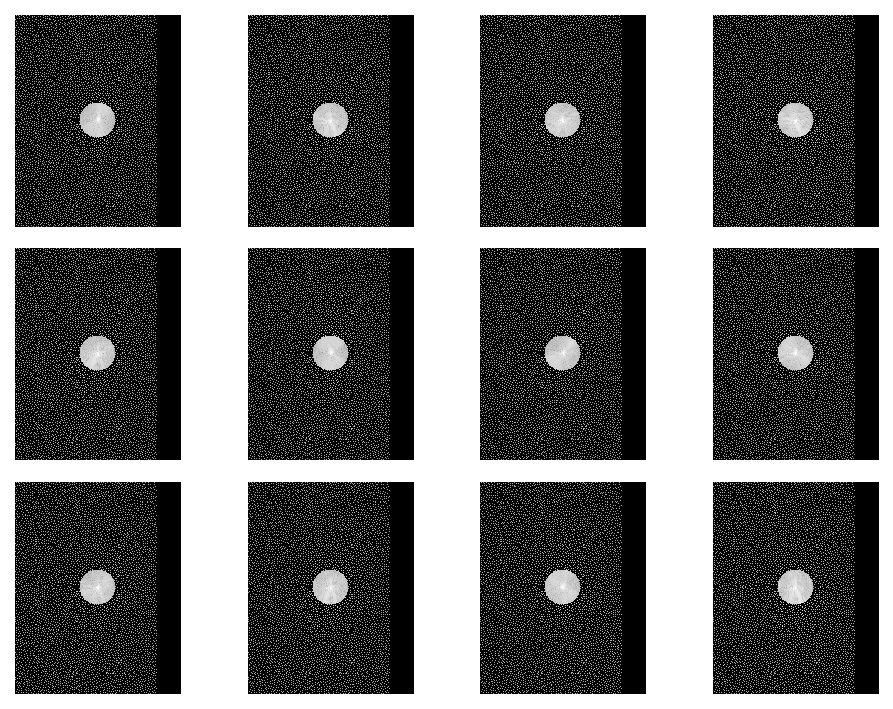

Channel-wise images


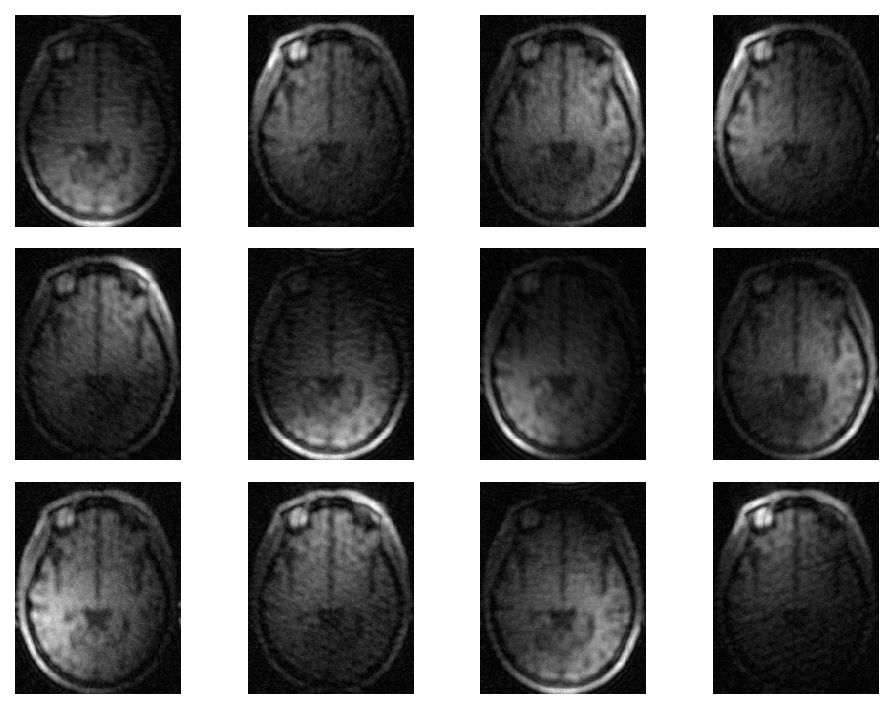

Zero-filled root sum of squares reconstruction


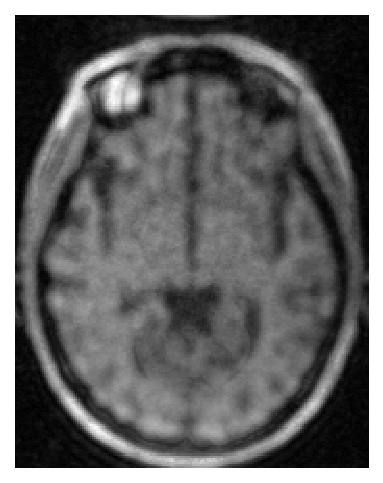

In [5]:
sample_kspace_r5 = sample_kspace.copy()
sample_kspace_r5[~sp_r5[0],:] = 0 # retrospective undersampling to R = 5


# Displaying channels' k-spaces
print("\n\nChannel-wise k-space")    

plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(3, 4)
gs1.update(wspace=0.002, hspace=0.1)

for ii in range(12):
    plt.subplot(gs1[ii])
    plt.imshow(np.log(1+np.abs(sample_kspace_r5[:,:,ii])),cmap = "gray")
    plt.axis("off")
plt.show()


# Displaying channels' images
print("Channel-wise images")    
sample_rec_train_r5 = np.fft.ifft2(sample_kspace_r5,axes = (0,1))

plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(3, 4)
gs1.update(wspace=0.002, hspace=0.1)

for ii in range(12):
    plt.subplot(gs1[ii])
    plt.imshow(np.abs(sample_rec_train_r5[:,:,ii]),cmap = "gray")
    plt.axis("off")
plt.show()

print("Zero-filled root sum of squares reconstruction")
sos2 = sum_of_squares(sample_rec_train_r5)
plt.figure(dpi = 150)
plt.imshow(sos2,cmap = "gray")
plt.axis("off")
plt.show()

The test sets are already undersampled. You only need to reconstruct them and submit your solutions either to Track 01 or Track 02 or both! An example for the 32-channel data appears below.

Number of volumes in the train set 50
Data format is x-ky-kz-nchannels
data shape: (256, 218, 180, 64)


Channel-wise k-space


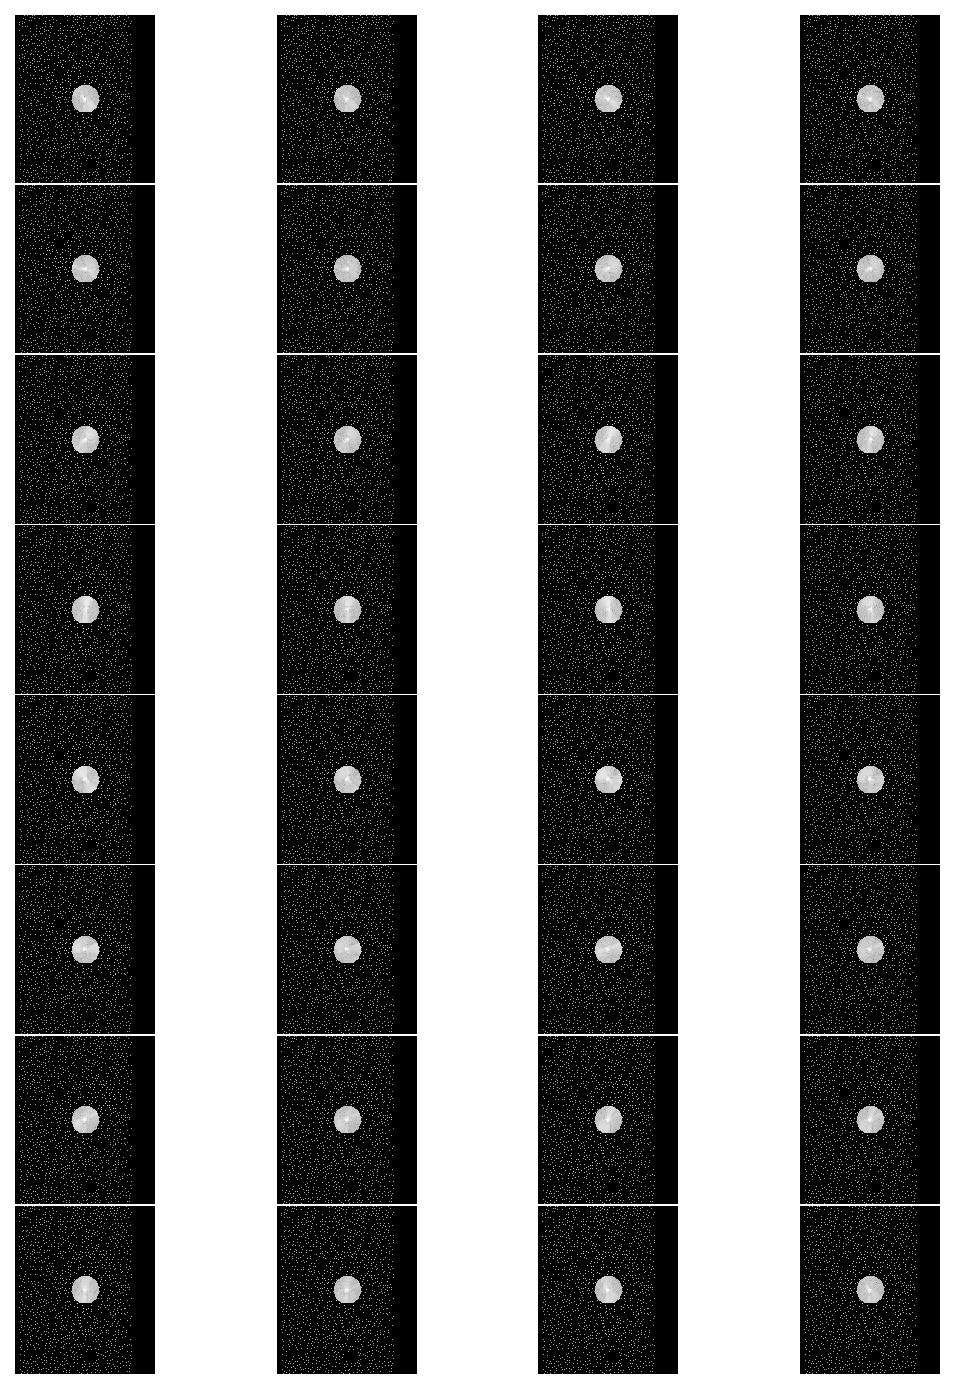

Channel-wise images


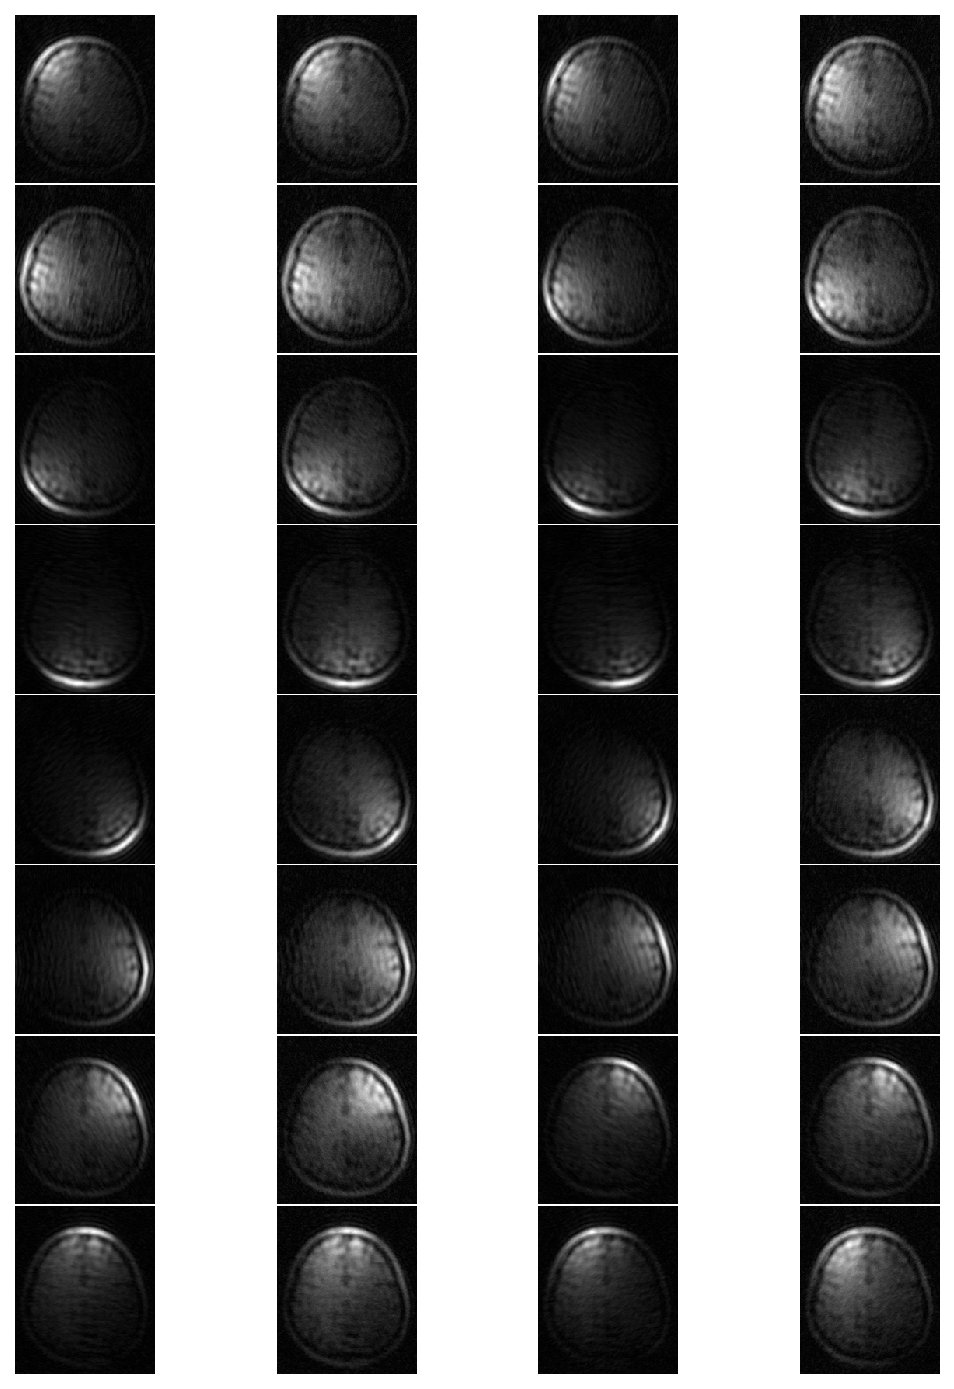

Zero-filled root sum of squares


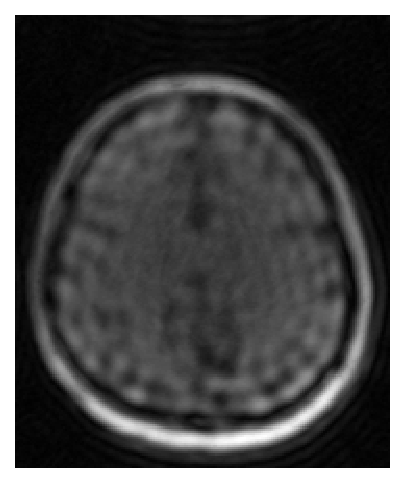

In [5]:
# 32-channel data
test_path = "/media/roberto/ROBERTO-5TB/GDrive/CC359/Raw-data/Multi-channel/32-channel/Test-R=10/*.h5"
test_files = np.asarray(glob.glob(test_path))
print("Number of volumes in the train set",len(test_files))

# Displaying a specific slice from a specific volume
file_index = 35
slice_index = 100

# Load .h5 file
with h5py.File(test_files[file_index], 'r') as f:
    sample_kspace3 = f['kspace'][:] # the key to access data is 'kspace'
    
    
print("Data format is x-ky-kz-nchannels")
print("data shape:",sample_kspace3.shape)

# We just want to show one slice
sample_kspace3 = sample_kspace3[slice_index]
# Converting to complex
sample_kspace3 = sample_kspace3[:,:,::2] + 1j*sample_kspace3[:,:,1::2]


print("\n\nChannel-wise k-space")    

# Displaying channels' k-spaces
plt.figure(figsize = (9,12),dpi = 150)
gs1 = gridspec.GridSpec(8, 4)
gs1.update(wspace=0.002, hspace=0.01)

for ii in range(32):
    plt.subplot(gs1[ii])
    plt.imshow(np.log(1+np.abs(sample_kspace3[:,:,ii])),cmap = "gray")
    plt.axis("off")
plt.show()

print("Channel-wise images")    
sample_rec_train3 = np.fft.ifft2(sample_kspace3,axes = (0,1)) # Only ky and kz are in k-space domain

# Displaying channels' images
plt.figure(figsize = (9,12),dpi = 150)
gs1 = gridspec.GridSpec(8, 4)
gs1.update(wspace=0.002, hspace=0.01)

for ii in range(32):
    plt.subplot(gs1[ii])
    plt.imshow(np.abs(sample_rec_train3[:,:,ii]),cmap = "gray")
    plt.axis("off")
plt.show()

print("Zero-filled root sum of squares")

sos3 = sum_of_squares(sample_rec_train3)
plt.figure(dpi = 150)
plt.imshow(sos3,cmap = "gray")
plt.axis("off")
plt.show()